# Object detection

Using the MNIST dataset, we will place numbers on different parts of a canvas. Then our model will put a bounding box around the numbers and also detect what number is inside. I would also like for the model to be able to identiy multiple numbers in the same picture if they are visible while also ignoring noise, like lines or symbols.

## 1. Dataset
The MNIST dataset has all the numbers in the center of the screen, we will need to make these images.

1. Using a black canvas we will place between 1 and 5 MNIST digits on the canvas on random locations
2. The digits will vary in size and the images will be rotated up to 10 degrees for variance
3. We will track the location of the bounding box
4. Save: image + labels (digit_class, x, y, width, height)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import random
import math

In [3]:
def load_mnist_data():
    transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, test_dataset

In [43]:
class DigitPlacer:
    def __init__(self, canvas_size=224, min_digit_size=20, max_digit_size=40, max_rotation=10):
        self.canvas_size = canvas_size
        self.min_digit_size = min_digit_size
        self.max_digit_size = max_digit_size
        self.max_rotation = max_rotation

    def process_single_digit(self, mnist_image, target_size=None, rotation_angle=None):
        mnist_array = mnist_image.squeeze().numpy() # Tensor to image
        mnist_array = (mnist_array * 255).astype(np.uint8) 

        digit_pil = Image.fromarray(mnist_array, mode='L')

        if target_size is None:
            target_size = random.randint(self.min_digit_size, self.max_digit_size)

        if rotation_angle is None:
            rotation_angle = random.uniform(-self.max_rotation, self.max_rotation)

        digit_resized = digit_pil.resize((target_size, target_size), Image.Resampling.LANCZOS)
        digit_rotated = digit_resized.rotate(rotation_angle, expand=True, fillcolor=0)

        return digit_rotated, target_size, rotation_angle
                
    def place_digit_on_canvas(self, canvas, digit_image, position=None):
        digit_width, digit_height = digit_image.size
        canvas_width, canvas_height = canvas.size

        if position is None:
            max_X = canvas_width - digit_width
            max_Y = canvas_height - digit_height

            x = random.randint(0, max_X)
            y = random.randint(0, max_Y)
        else:
            x, y = position

        new_canvas = Image.new('L', (self.canvas_size, self.canvas_size), color=(0))
        new_canvas.paste(digit_image, (x,y))

        # Since black is 0 and white is 255 we can add the arrays of two images to just transfer the white - in this case the stroke of the digit
        canvas_array = np.array(canvas, dtype=np.float32)
        new_canvas_array = np.array(new_canvas, dtype=np.float32)

        canvas_array = np.minimum(canvas_array + new_canvas_array, 255)
        updated_canvas = Image.fromarray(canvas_array.astype(np.uint8))

        return updated_canvas, (x, y, digit_width, digit_height)


In [46]:
canvas = Image.new('L', (224, 224), color=(0))
placer = DigitPlacer(224)
annotations = [] # Empty array for annotations

train_dataset, test_dataset = load_mnist_data()

for i in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    mnist_image, digit_class = train_dataset[idx]

    processed_digit, size, rotation = placer.process_single_digit(mnist_image)
    canvas, bbox = placer.place_digit_on_canvas(canvas, processed_digit)

    if bbox is not None:
        #x, y, width, height = bbox
        annotations.append({
            'class':digit_class,
            'bbox': bbox,
            'size': size,
            'rotation': rotation
        })

C:\Users\filip\AppData\Local\Temp\ipykernel_3032\2370921591.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  digit_pil = Image.fromarray(mnist_array, mode='L')


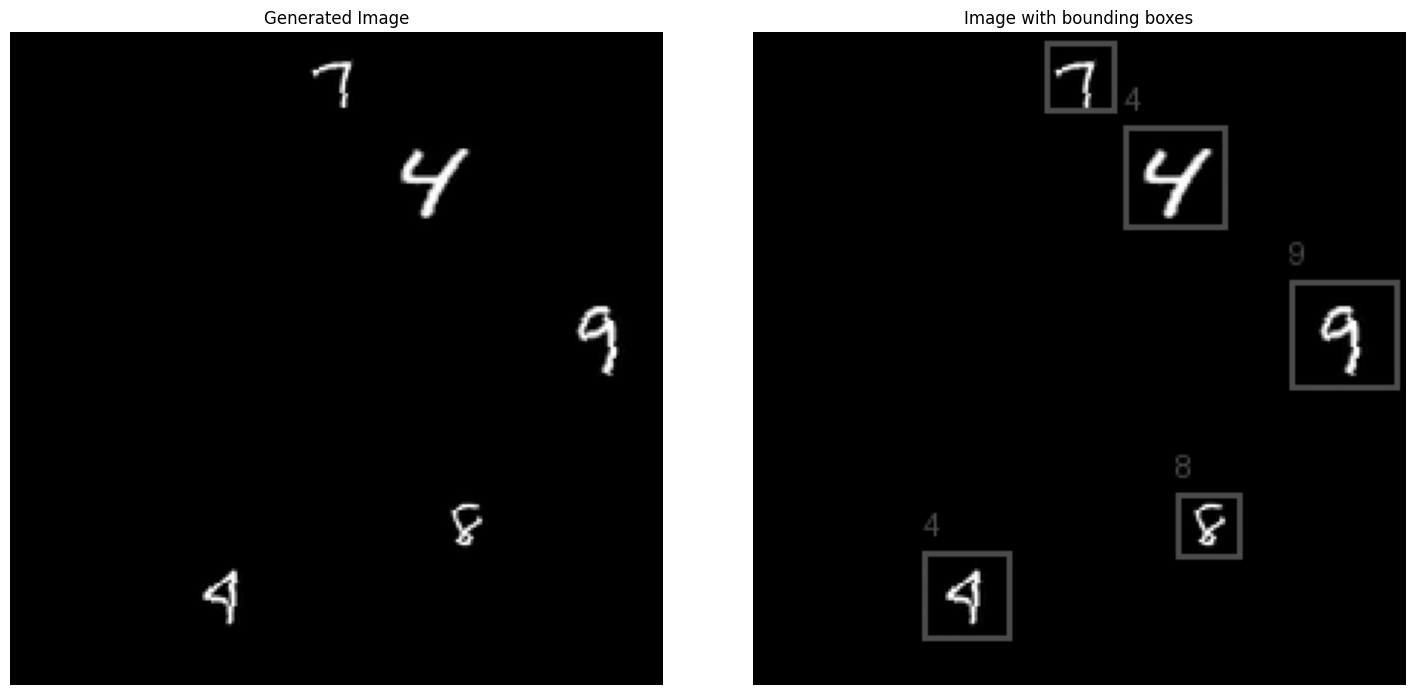

In [47]:
canvas_with_bbox = canvas.copy()
draw = ImageDraw.Draw(canvas_with_bbox)

for i, ann in enumerate(annotations):
    digit_class = ann['class']
    x, y, width, height = ann['bbox']

    # Draw rectangle
    draw.rectangle([x, y, x+width, y+height], outline='green', width=2)
    label = f'{digit_class}'
    draw.text((x, y-15), label, fill='green')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Original image
ax1.imshow(canvas, cmap='gray')
ax1.set_title("Generated Image")
ax1.axis('off')

# Image with boudning box
ax2.imshow(canvas_with_bbox, cmap='gray')
ax2.set_title("Image with bounding boxes")
ax2.axis('off')

plt.tight_layout()
plt.show()

Now that the algorithm for data synthesis works, we can work on creating a dataset alongside labels for the model to train on

We are going to split the data as 5:1:1 between train, validate and test
Hence, for a 1000 training dataset, we will need 200 val and 200 test

In [93]:
def generate_image(mnist_dataset, placer, min_digits=1, max_digits=5):
    num_digits = np.random.randint(min_digits, max_digits + 1)
    canvas = Image.new('L', (224, 224), color=(0))
    annotations = []
    for i in range(num_digits):
        idx = random.randint(0, len(mnist_dataset) - 1)
        mnist_image, digit_class = mnist_dataset[idx]

        processed_digit, size, rotation = placer.process_single_digit(mnist_image)
        canvas, bbox = placer.place_digit_on_canvas(canvas, processed_digit)

        if bbox is not None:
            annotations.append({
                'class':digit_class,
                'bbox': bbox,
                'size': size,
                'rotation': rotation
            })

    return canvas, annotations

1
[{'class': 0, 'bbox': (103, 179, 30, 30), 'size': 28, 'rotation': -3.7194389497795433}]


C:\Users\filip\AppData\Local\Temp\ipykernel_3032\2370921591.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  digit_pil = Image.fromarray(mnist_array, mode='L')


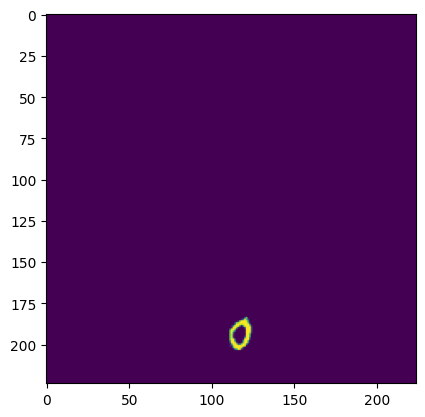

In [82]:
# test
canvas, a = generate_image(train_dataset, placer)

print(a)

plt.imshow(canvas)

In [94]:
# Normalise labels
def normalise_annotations(annotations, canvas):
    img_width, img_height = canvas.size
    norm_annotations = []

    for a in annotations:
        x, y, w, h = a['bbox']

        # Convert to center coordinates
        x_center = x + w/2
        y_center = y + h/2

        # Normalise bbox to image dimensions
        x_center_norm = x_center / img_width    
        y_center_norm = y_center / img_height
        width_norm = w / img_width
        height_norm = h / img_height

        # Clamp values between 0 and 1 - should already be close...
        x_center_norm = max(0, min(1, x_center_norm))
        y_center_norm = max(0, min(1, y_center_norm))
        width_norm = max(0, min(1, width_norm))
        height_norm = max(0, min(1, height_norm))

        norm_annotations.append({
            'class':a['class'],
            'bbox': (x_center_norm, y_center_norm, width_norm, height_norm),
            'size': a['size'],
            'rotation': a['rotation']
            })

    return norm_annotations

In [87]:
print(normalise_annotations(a, canvas))

{'class': 0, 'bbox': (103, 179, 30, 30), 'size': 28, 'rotation': -3.7194389497795433}
(103, 179, 30, 30)
[{'class': 0, 'bbox': (0.5267857142857143, 0.8660714285714286, 0.13392857142857142, 0.13392857142857142), 'size': 28, 'rotation': -3.7194389497795433}]


In [95]:
import os

def store_image(image, annotations, split_name):
    img_filename = f"{split_name}_{i:06d}.jpg"
    img_path = os.path.join('./data/mnist_detection_dataset/images', split_name, img_filename)

    if image.mode != "RGB":
        image = image.convert('RGB')

    image.save(img_path, 'JPEG', quality=95)

    label_filename = f"{split_name}_{i:06d}.txt"
    label_path = os.path.join('./data/mnist_detection_dataset/labels', split_name, label_filename)

    with open(label_path, 'w') as f:
        for ann in annotations:
            class_id = ann['class']
            bbox = ann['bbox']

            f.write(f"{class_id} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

In [98]:
# Generate and store images in appropriate files

train = 1000
val = int(train * (1/5))
test = val

for i in range(train):
    image, annotations = generate_image(train_dataset, placer)
    annotations = normalise_annotations(annotations, image)
    store_image(image, annotations, "train")

for i in range(val):
    image, annotations = generate_image(train_dataset, placer)
    annotations = normalise_annotations(annotations, image)
    store_image(image, annotations, "val")

for i in range(val):
    image, annotations = generate_image(test_dataset, placer)
    annotations = normalise_annotations(annotations, image)
    store_image(image, annotations, "test")


C:\Users\filip\AppData\Local\Temp\ipykernel_3032\2370921591.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  digit_pil = Image.fromarray(mnist_array, mode='L')


## 1.2 Loading the data

After we created the data, we also need to consider how to data is going to be loaded. Since we are using PyTorch, we will need to use a PyTorch Tensor.

In [102]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms

In [119]:
def load_data(data_dir, split='train', img_size=224):
    images_dir = os.path.join(data_dir, 'images', split)
    label_dir = os.path.join(data_dir, 'labels', split)

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    images = []
    annotations = []

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    image_files.sort()

    for img_name in image_files:
        img_path = os.path.join(images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = transform(image)

        label_name = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_name)

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])

                        labels.append(class_id)
                        boxes.append([x_center, y_center, width, height])

        images.append(image)
        annotations.append({
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.long)
        })
    
    return images, annotations

In [120]:
""" The DataLoader expects the data collated """
def collate_fn(batch):
    images, targets = zip(*batch)
    return torch.stack(images), list(targets)

In [129]:
""" Loading the data and validating it """

from torch.utils.data import DataLoader

BATCH_SIZE = 16

# Loading the data into memory
train_images, train_labels  = load_data('./data/mnist_detection_dataset', 'train')
test_images, test_labels = load_data('./data/mnist_detection_dataset', 'val')

train_dataset = list(zip(train_images, train_labels))
test_dataset = list(zip(test_images, test_labels))

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

{'boxes': tensor([[0.9018, 0.5536, 0.1518, 0.1518],
        [0.2232, 0.4107, 0.1607, 0.1607],
        [0.9085, 0.4621, 0.1562, 0.1562],
        [0.1562, 0.2366, 0.1429, 0.1429],
        [0.6585, 0.8237, 0.1562, 0.1562]]), 'labels': tensor([5, 6, 2, 1, 1])}


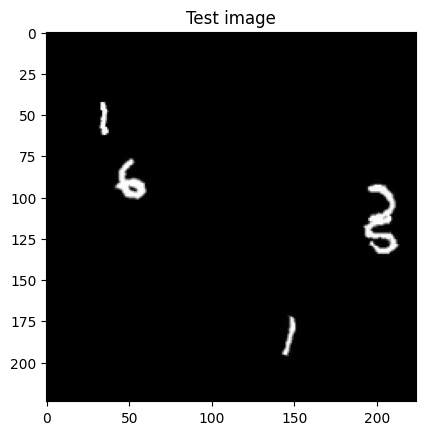

In [155]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

images, labels = next(iter(train_loader))
print(labels[0])

image = images[0].permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title("Test image")
plt.show()


## 2. Object Detection architecture
In classification the model takes one image and makes a prediction.
In detection we also have to figure out where something is. We will need to first perform feature extraction, then detect and see if we can identify something. 

The backbone of Feature Extraction is CNN - Convolutional Neural Network which basically means that a Convolutional layer - or layers - perform feature extraction on the input.

## 3. Loss function

Until now the loss function was just a product of the confidence and classofication loss, but now it will need to also include a localisation loss

1. Localisation loss - MSE between predicted (x,y,w,h) and true (x,y,w,h)
2. Classification loss - CrossEntropy between predicted class and true class
3. Confidence loss - 
    for cells **WITH** objects: BCE(predicted_conf, 1)
    for cells **WITHOUT** objects: BCE(predicted_conf, 0)
